In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from src import measures
from src.separator import Separator
from src.cleaner import DoubleStepCleaner

In [52]:
fpath = "/autofs/LSDF/projects/code-vita/Medaka/2018_11/"
fls = os.listdir(fpath)
id = np.random.choice(fls)
img_path = fpath + id + "/scaled_0.5_8bit_cropped_slices.tif"
msk_path = fpath + id + "/heartkidney_scaled_0.5_8bit_cropped_slices.tif"

print(id)
img = tifffile.imread(img_path)
msk = tifffile.imread(msk_path)


#img = tifffile.imread("/autofs/LSDF/projects/code-vita/Medaka/2018_11/Medaka_508_33-1/scaled_0.5_8bit_cropped_slices.tif")
#msk = tifffile.imread("/autofs/LSDF/projects/code-vita/Medaka/2018_11/Medaka_508_33-1/heartkidney_scaled_0.5_8bit_cropped_slices.tif")

Medaka_598_59-2


(2160, 560, 592)
[0 0 0]
1676


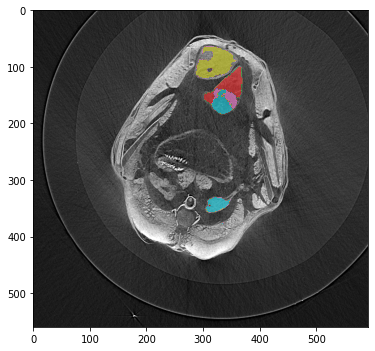

In [55]:
ne_slc = np.where(msk.sum((1, 2))>0)[0]
slice_id = ne_slc[len(ne_slc)//2]
slice_id = np.argmax(msk.sum((1, 2)))

print(msk.shape)
print(np.array(msk.shape) - np.array(img.shape))
print(slice_id)

plt.figure(figsize=(6, 6))
plt.imshow(img[slice_id], cmap='gray')
plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*0.7)
plt.show()

In [80]:
cleaning_config = {
    'bounding_boxes': 2,
    'bbox_cleaning_type': '1d',
    'connected_areas_per_label':
        [
            {'id': 1, 'connected_regions': 1},
            {'id': 2, 'connected_regions': 1},
            {'id': 3, 'connected_regions': 1},
            {'id': 4, 'connected_regions': 1},
            {'id': 5, 'connected_regions': 1},
            {'id': 6, 'connected_regions': 1}
        ]
    }

In [81]:
cleaner = DoubleStepCleaner(**cleaning_config)

In [82]:
msk_clean, roi = cleaner(msk)
img_clean = img[roi]

print(roi)
print(msk_clean.shape)

(slice(1569, 1719, None), slice(63, 395, None), slice(208, 380, None))
(150, 332, 172)


(150, 332, 172)
[0 0 0]
108


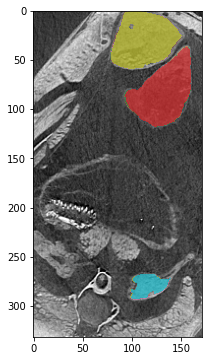

In [83]:
ne_slc = np.where(msk_clean.sum((1, 2))>0)[0]
slice_id = ne_slc[len(ne_slc)//2]
slice_id = np.argmax(msk_clean.sum((1, 2)))

print(msk_clean.shape)
print(np.array(msk_clean.shape) - np.array(img_clean.shape))
print(slice_id)

plt.figure(figsize=(6, 6))
plt.imshow(img_clean[slice_id], cmap='gray')
plt.imshow(msk_clean[slice_id], cmap='tab10', alpha=(msk_clean[slice_id]>0)*0.7)
plt.show()

# till here

In [8]:
centering_config = [
    {
      'label_id': 3,
      'function': 'proba',
      'name': 'lens',
      'count': 2
    }
]

In [17]:
centers = {}
for centering in centering_config:
    centers[centering['name']] = Separator((msk == centering['label_id']), centering['function'], centering['count'])
    
print(centers)    

{'lens': <src.separator.Separator object at 0x7fe94e96adc0>}


In [10]:
measuring_config = [
    {
        'id': 1,
        'name': 'iris',
        'center': 'lens',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'distance_between_centers'}
        ]
    },
    {
        'id': 3,
        'name': 'lens',
        'center': 'lens',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'thickness_axial'},
            {'function': 'radius_axial'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'distance_between_centers'}
        ]
    },
    {
        'id': 4,
        'name': 'muscles',
        'center': 'lens',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'distance_between_centers'}
        ]
    },
    {
        'id': 5,
        'name': 'nerve',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'}
        ]
    },
    {
        'id': 6,
        'name': 'retina',
        'center': 'lens',
        'measures':
        [
            {'function': 'volume'},
            {'function': 'surface_area'},
            {'function': 'color_average'},
            {'function': 'color_std'},
            {'function': 'eccentricity_meridional'},
            {'function': 'distance_between_centers'}
        ]
    }
]

In [15]:
for label in measuring_config:
    label_mask = (msk == label['id'])
    print(label['id'])
    for measure in label['measures']:
        mf = getattr(measures, measure['function'])
        cc = centers[label['center']] if ('center' in label.keys()) else None
        measurement = mf(label_mask, img, cc)
        print(measure['function'],measurement)

1
volume [51653, 67830]
surface_area [33530, 35824]
color_average [131.2708651966004, 137.55336871590742]
color_std [23.695933959612354, 25.435804700721253]
eccentricity_meridional [0.6594506520784756, 0.6774481022804199]
distance_between_centers [329.3760193469411]
3
volume [86185, 83358]
surface_area [39032, 38293]
thickness_axial [[(6, 6), (6, 6), (8, 6)], [(5, 6), (6, 7), (6, 7)]]
radius_axial [[(33.71684167778619, 33.28315832221381), (32.87054591866334, 33.12945408133666), (31.751290827870292, 34.24870917212971)], [(32.88981261546587, 33.11018738453413), (33.034585762614256, 31.965414237385744), (33.915233091005064, 32.084766908994936)]]
color_average [226.99315426118235, 227.95327383094605]
color_std [51.26659336547504, 49.12220734665223]
distance_between_centers [218.86113681710114]
4
volume [30961, 35205]
surface_area [42084, 42365]
color_average [156.56774651981524, 151.85627041613407]
color_std [34.23138244449188, 39.13394589844375]
eccentricity_meridional [0.4708576397470669